#### Imports

In [1]:
# %pip install missingno

In [2]:
import src.web_scraping.download_countries
import src.web_scraping.downloading_metrics as downloading
from src.web_scraping.save_countries import save_countries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import seaborn as sns
import src.visualisations.plotting_utilis as my_plt
import src.data_preprocessing.utils as preprocess_utils
from ydata_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import missingno as msno

Download geographic overview
Done


### How Data Is Acquired

Data is scraped from website https://www.cia.gov/the-world-factbook where each country has it's own value for a given metric. Change 'download' to True to download data

In [3]:
# TODO: remove metrics which are not used 
download = True

save_countries()
if download:
    downloading.download_metrics(downloading.METRICS)

### Explanatory Data Analysis

First, we'll explore the predictor variable

In [4]:
median_age = preprocess_utils.get_median_age()

Dropping:  Index(['Holy See'], dtype='object', name='country')


<Figure size 432x360 with 0 Axes>

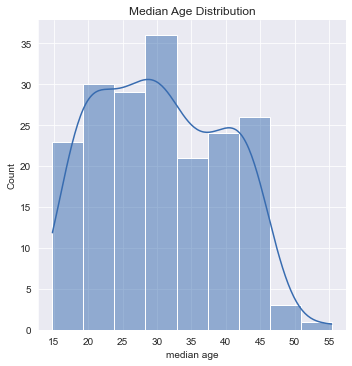

In [5]:
plt.figure(figsize=(6, 5))
sns.displot(data=median_age, kde=True, color=colormaps['Accent'](0.6))
_ = plt.title('Median Age Distribution')

In [6]:
median_age.describe().round(2)

count    193.00
mean      30.57
std        9.10
min       14.80
25%       23.50
50%       29.80
75%       38.40
max       55.40
Name: median age, dtype: float64

In [7]:
sorted_age = median_age.sort_values()
print(sorted_age.index[0], sorted_age[0])
print(sorted_age.index[-1], sorted_age[-1])

Niger 14.8
Monaco 55.4


##### Fitting median age to distribution

Here we'll perform statistical tests for the normality of data. Because p-values are very small, we can reject the null hypothesis that the data is normally distributed

In [8]:
from scipy import stats 

shapiro_result = stats.shapiro(median_age)
normaltest_result = stats.normaltest(median_age)

print(round(shapiro_result.pvalue, 8))
print(round(normaltest_result.pvalue, 8))

4.35e-05
4e-08


##### Median Age By Region

Next, we'll see whether median age depends on the continent

In [9]:
country_continents = preprocess_utils.assign_continents(median_age.index)
continents = list(np.unique(country_continents.values))
continent_count = country_continents.value_counts()
continent_count

continent    
Africa           53
Asia             47
Europe           44
North America    23
Oceania          14
South America    12
dtype: int64

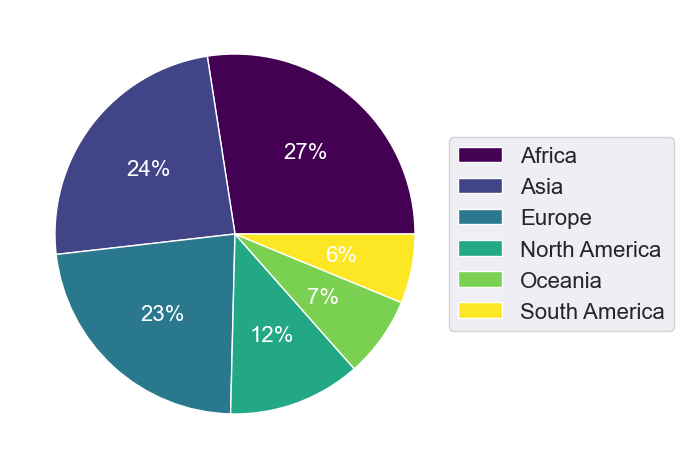

In [10]:
c = colormaps['viridis'](np.linspace(0, 1, len(continent_count)))[:, :3]

fig_6 = plt.figure(figsize=(8,5), dpi=100)
axes_6 = fig_6.add_axes([0.1, 0.1, 0.9, 0.9])

wedges, texts, autotexts = plt.pie(continent_count, labels=continents, 
                                  colors=c, autopct='%1.0f%%', 
                                  textprops={'color': 'w', 'size': 16})

plt.legend(wedges, continents, loc='right', bbox_to_anchor=(1, 0, 0.5, 1), 
           fontsize=16) 

As expected, the median age distribution depends on the continent. For example, in Europe we can see the phenomenon of population-ageing, and for Africa the prevalence of youth & children lowers the median age.

C:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
 

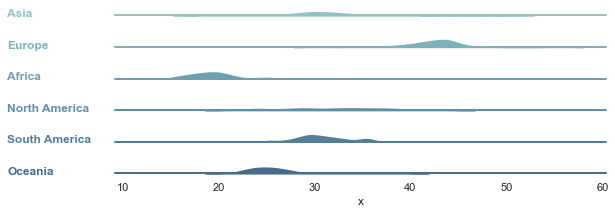

In [11]:
my_plt.plot_joyplot(median_age, country_continents['continent'])

##### Scatterplots

Next, we'll visually analyze relationship of median age with different numerical metrics and the distributions of those metrics.



In [12]:
country_metrics = preprocess_utils.merge_metrics(median_age.index)
country_metrics.describe().transpose()[['count', 'mean', 'std']]

,count,mean,std
alcohol consumption per capita,186.0,4.702581e+00,3.686874e+00
tobacco use total,162.0,2.033272e+01,9.856951e+00
women marriage by 18,73.0,2.228630e+01,1.396726e+01
men marriage by 18,52.0,4.765385e+00,4.672694e+00
currently married women ages 15-49,190.0,5.783684e+01,8.646026e+00
birth rate,193.0,1.834228e+01,9.156810e+00
life expectancy,193.0,7.402731e+01,6.861937e+00
death rate,193.0,7.529223e+00,2.675843e+00
agriculture occupation ratio,177.0,2.919356e+01,2.731340e+01
industry occupation ratio,174.0,1.935000e+01,9.413431e+00


<AxesSubplot:>

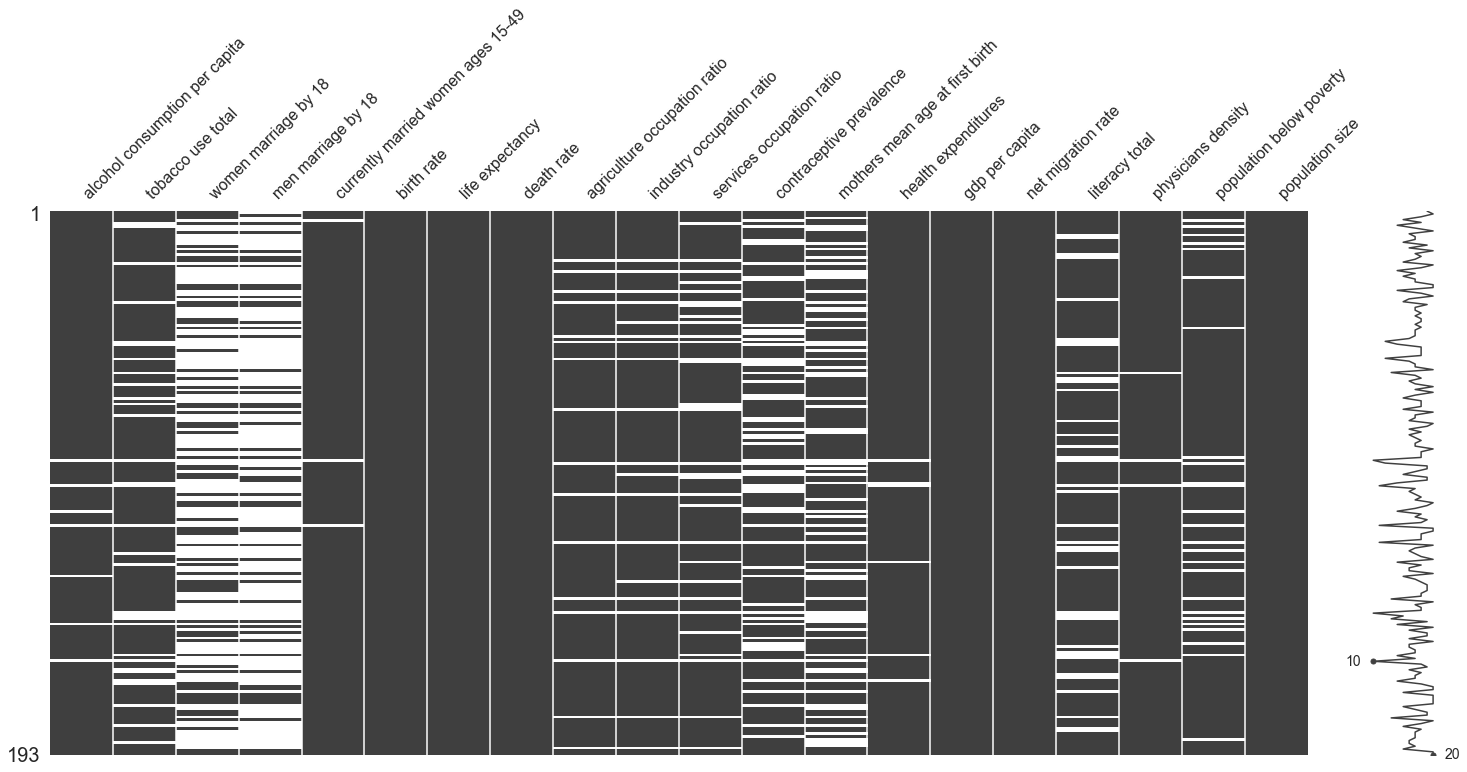

In [13]:
msno.matrix(country_metrics)

Features with many missing values will be dropped  

In [14]:
percentage_missing_values = round(country_metrics.isna().mean() * 100, 2)
percentage_missing_values 

alcohol consumption per capita         3.63
tobacco use total                     16.06
women marriage by 18                  62.18
men marriage by 18                    73.06
currently married women ages 15-49     1.55
birth rate                             0.00
life expectancy                        0.00
death rate                             0.00
agriculture occupation ratio           8.29
industry occupation ratio              9.84
services occupation ratio             16.06
contraceptive prevalence              27.46
mothers mean age at first birth       32.64
health expenditures                    3.11
gdp per capita                         0.00
net migration rate                     0.00
literacy total                        19.17
physicians density                     2.07
population below poverty              12.95
population size                        0.00
dtype: float64

In [15]:
dropped_columns = preprocess_utils.drop_columns_with_percent_of_nulls(country_metrics)
dropped_columns

Index(['women marriage by 18', 'men marriage by 18'], dtype='object')

Distribution for all metrics

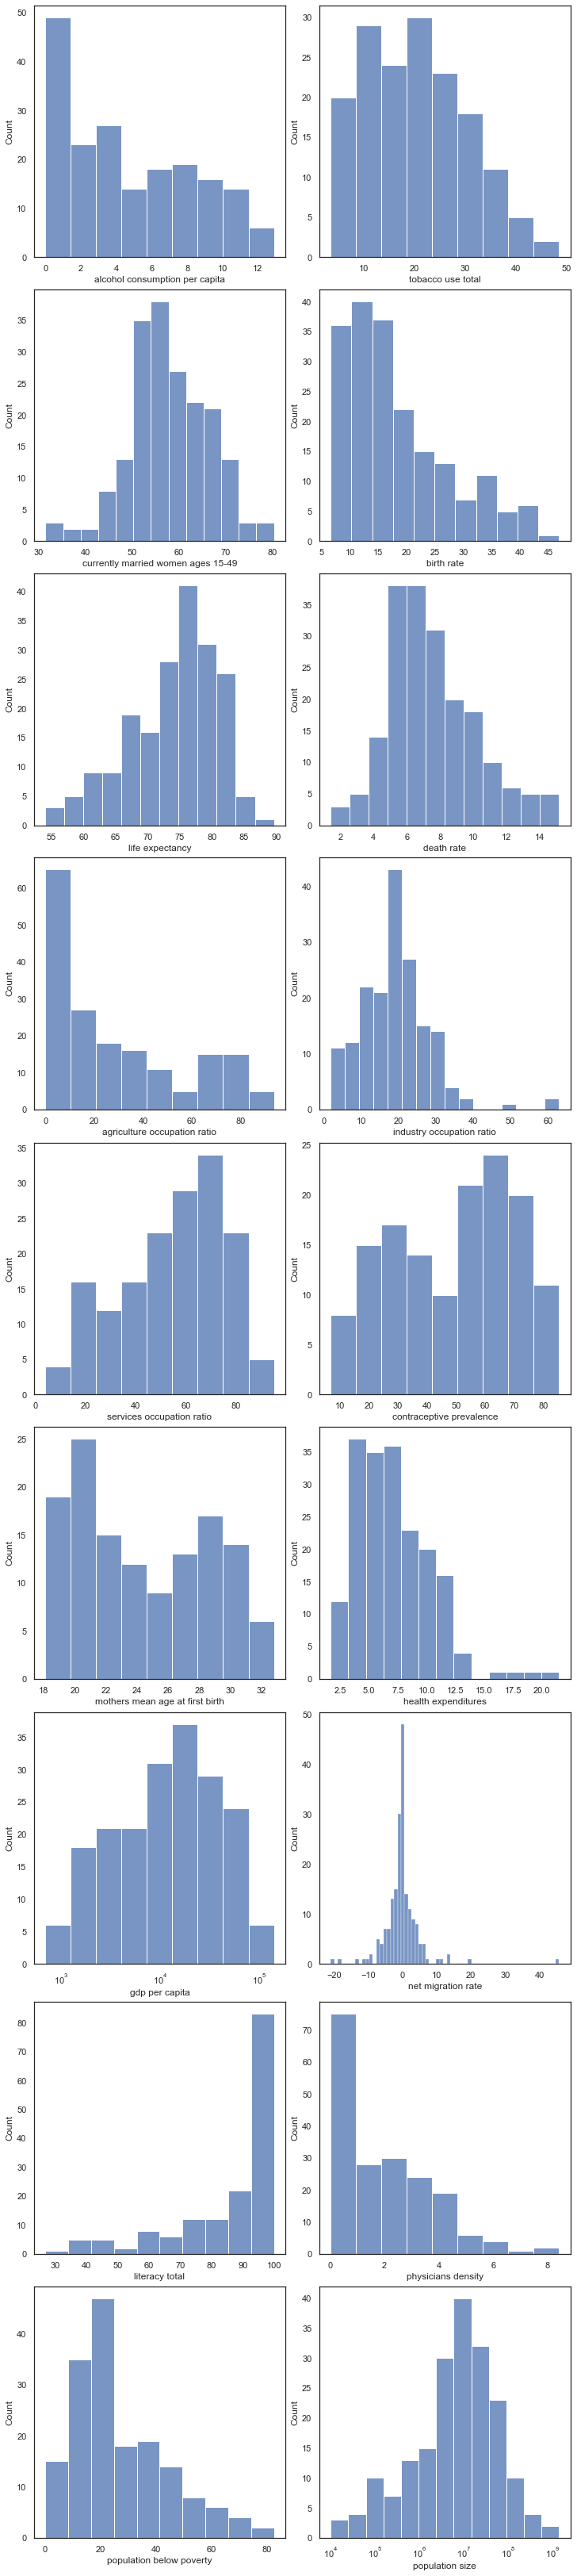

In [16]:
my_plt.plot_data_distributions(country_metrics, country_metrics.columns, log_scales={'population size', 
                                                                                     'gdp per capita'})

Scatter plots

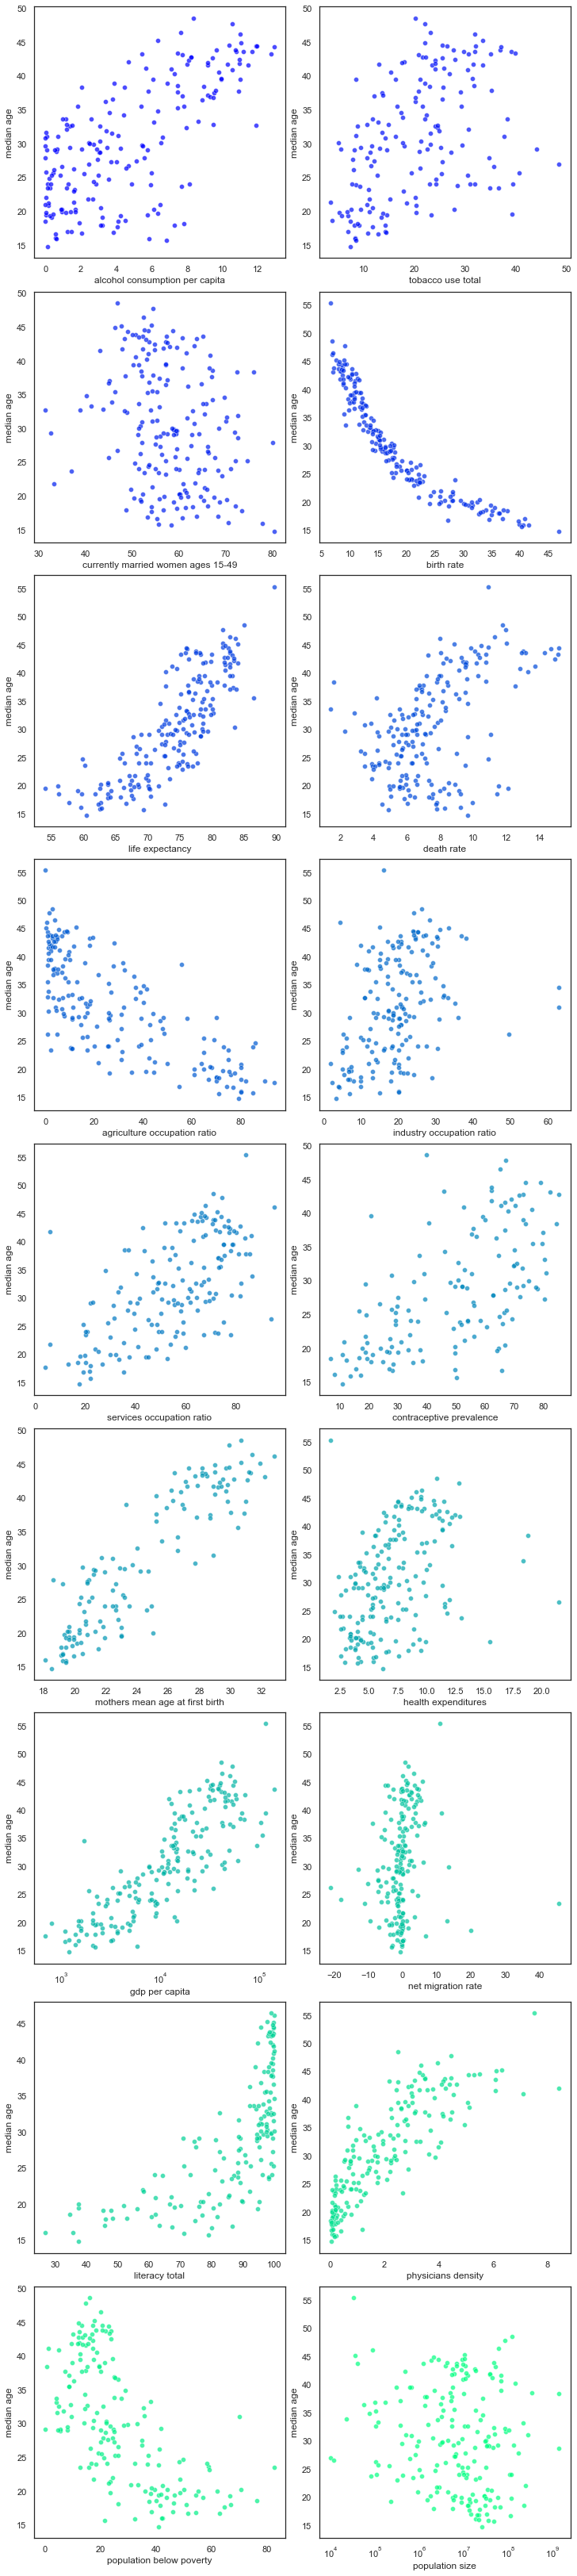

In [17]:
my_plt.create_scatter_plots(median_age, country_metrics, country_metrics.columns, log_scales={'population size', 'gdp per capita'}, n_cols=2)

#### Feature Selection

Pearson correlation coefficient measures the linear relationship between variables

In [18]:
pearson_corr_with_median_age = country_metrics.corrwith(median_age, method='pearson')
abs_pearson_corr_with_median_age = pearson_corr_with_median_age.apply(lambda x: abs(x))
pearson_corr_with_median_age.name = 'pearson'

Spearman's rank correlation coefficient is a nonparametric measure of rank correlation - statistical dependence between the rankings of two variables. It assesses how well the relationship between two variables can be described using monotonic function. Mathematically, it is roughly the same as pearson correlation coefficient between ranking of values. 



In [19]:
spearman_corr_with_median_age = country_metrics.corrwith(median_age, method='spearman')
spearman_corr_with_median_age.name = 'spearman'

In [20]:
corr_with_median_age = pd.concat([pearson_corr_with_median_age, spearman_corr_with_median_age], 
                                 axis=1)
corr_sorted = corr_with_median_age.sort_values(by=['pearson', 'spearman'], key=lambda x: abs(x))

#### Drop features without any significant pattern
 Population size and net migration rate don't seem to vary with median age, so we'll drop them

In [21]:
pearson_corr_with_median_age

alcohol consumption per capita        0.694585
tobacco use total                     0.450943
currently married women ages 15-49   -0.272118
birth rate                           -0.914454
life expectancy                       0.816318
death rate                            0.499398
agriculture occupation ratio         -0.761699
industry occupation ratio             0.378867
services occupation ratio             0.637108
contraceptive prevalence              0.616902
mothers mean age at first birth       0.901760
health expenditures                   0.405801
gdp per capita                        0.680552
net migration rate                    0.157696
literacy total                        0.699223
physicians density                    0.831301
population below poverty             -0.646274
population size                       0.019296
Name: pearson, dtype: float64

In [22]:
country_metrics.drop(['population size', 'net migration rate',
                      'currently married women ages 15-49'], axis=1, inplace=True)

##### Relationships between features

For now, all features were considered separately from others, but we should deal with the ones that are dependent on another. 

In [23]:
correlation_matrix = pd.concat([country_metrics, median_age], axis=1).corr(method='spearman')
correlation_matrix

,alcohol consumption per capita,tobacco use total,birth rate,life expectancy,death rate,agriculture occupation ratio,industry occupation ratio,services occupation ratio,contraceptive prevalence,mothers mean age at first birth,health expenditures,gdp per capita,literacy total,physicians density,population below poverty,median age
alcohol consumption per capita,1.000000,0.207426,-0.620472,0.481475,0.559444,-0.516518,0.119089,0.469731,0.515362,0.633421,0.443914,0.564024,0.502090,0.564039,-0.341241,0.650629
tobacco use total,0.207426,1.000000,-0.492236,0.302670,0.285564,-0.270776,0.234551,0.238602,0.169650,0.480932,0.253826,0.280239,0.497261,0.426277,-0.377307,0.495163
birth rate,-0.620472,-0.492236,1.000000,-0.812693,-0.436383,0.739343,-0.444369,-0.598330,-0.654063,-0.850867,-0.445419,-0.829779,-0.788574,-0.852069,0.675151,-0.979925
life expectancy,0.481475,0.302670,-0.812693,1.000000,0.063176,-0.789711,0.363581,0.621547,0.595789,0.858875,0.459266,0.852524,0.672925,0.779154,-0.642459,0.833837
death rate,0.559444,0.285564,-0.436383,0.063176,1.000000,-0.233896,0.211268,0.270083,0.146295,0.422810,0.349707,0.231104,0.239435,0.373217,-0.186853,0.472916
agriculture occupation ratio,-0.516518,-0.270776,0.739343,-0.789711,-0.233896,1.000000,-0.410869,-0.848838,-0.578839,-0.822907,-0.533646,-0.852392,-0.668245,-0.771352,0.514056,-0.770108
industry occupation ratio,0.119089,0.234551,-0.444369,0.363581,0.211268,-0.410869,1.000000,0.222762,0.343515,0.449879,0.094864,0.436134,0.310766,0.358114,-0.345529,0.446435
services occupation ratio,0.469731,0.238602,-0.598330,0.621547,0.270083,-0.848838,0.222762,1.000000,0.487247,0.737549,0.536234,0.671503,0.594246,0.707353,-0.314824,0.633004
contraceptive prevalence,0.515362,0.169650,-0.654063,0.595789,0.146295,-0.578839,0.343515,0.487247,1.000000,0.471149,0.386582,0.566776,0.481640,0.598494,-0.488963,0.642664
mothers mean age at first birth,0.633421,0.480932,-0.850867,0.858875,0.422810,-0.822907,0.449879,0.737549,0.471149,1.000000,0.574865,0.863852,0.746859,0.813093,-0.702873,0.883191


Correlation matrix will help us spot relationships between features so we can further remove them

In [24]:
correlation_matrix['birth rate']

alcohol consumption per capita    -0.620472
tobacco use total                 -0.492236
birth rate                         1.000000
life expectancy                   -0.812693
death rate                        -0.436383
agriculture occupation ratio       0.739343
industry occupation ratio         -0.444369
services occupation ratio         -0.598330
contraceptive prevalence          -0.654063
mothers mean age at first birth   -0.850867
health expenditures               -0.445419
gdp per capita                    -0.829779
literacy total                    -0.788574
physicians density                -0.852069
population below poverty           0.675151
median age                        -0.979925
Name: birth rate, dtype: float64

<AxesSubplot:>

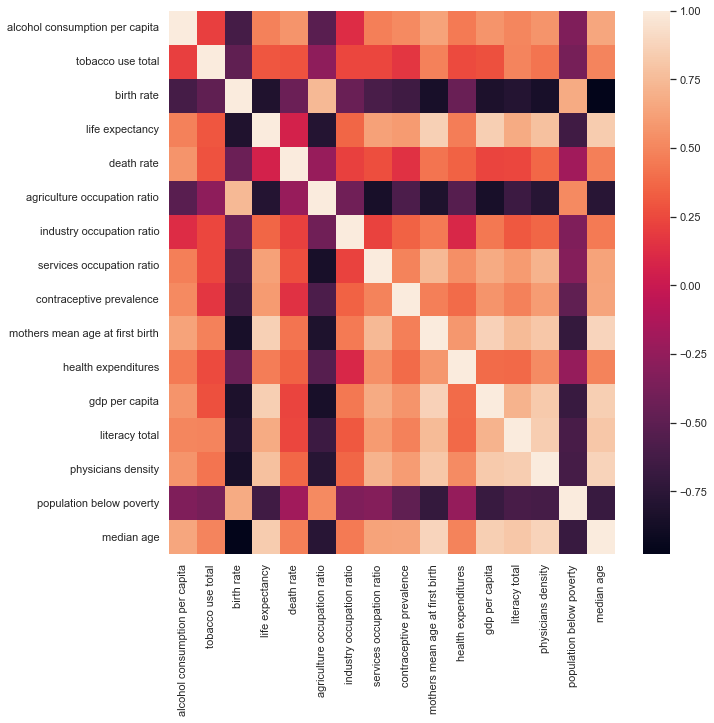

In [25]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix)

Occupation ratios of agriculture, services and industry should sum to 100, so we need only two of them

In [26]:
country_metrics[['agriculture occupation ratio', 'services occupation ratio', 
                 'industry occupation ratio']].sum(axis=1)

country
Afghanistan    100.0
Albania        100.0
Algeria        100.1
Andorra        100.0
Angola         100.0
               ...  
Venezuela      100.0
Vietnam        100.0
Yemen            0.0
Zambia         100.0
Zimbabwe       100.0
Length: 193, dtype: float64

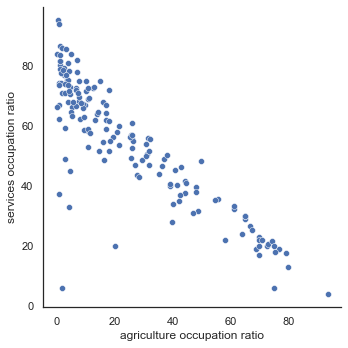

In [27]:
sns.relplot(data=country_metrics, x='agriculture occupation ratio', y='services occupation ratio')
country_metrics.drop(['agriculture occupation ratio'], axis=1, inplace=True)

Some metrics strongly depend on the birth rate. We'll first more closely observe these relationships and how they very for each continent.

In [28]:
threshold = 0.8
features = correlation_matrix['birth rate'].drop(['birth rate', 'median age'])
corr_feat_dep_on_birth_rate = features[np.abs(features) > threshold] 
features_dependent_on_birth_rate = corr_feat_dep_on_birth_rate.index
corr_feat_dep_on_birth_rate

life expectancy                   -0.812693
mothers mean age at first birth   -0.850867
gdp per capita                    -0.829779
physicians density                -0.852069
Name: birth rate, dtype: float64

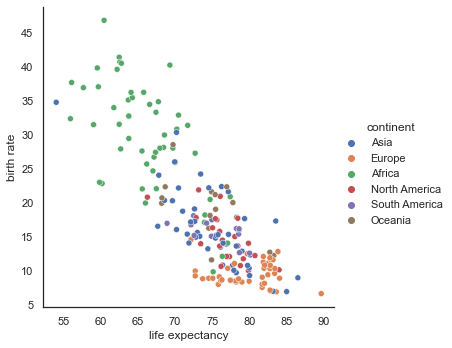

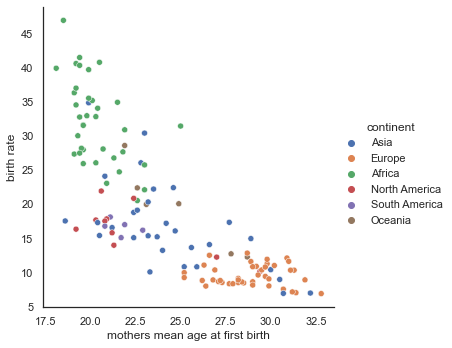

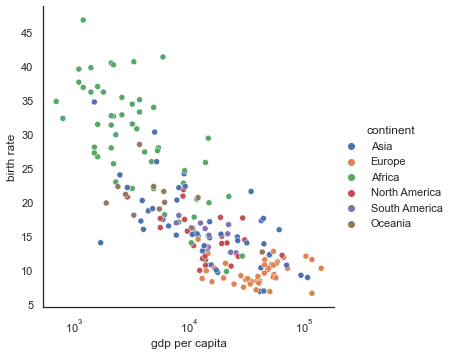

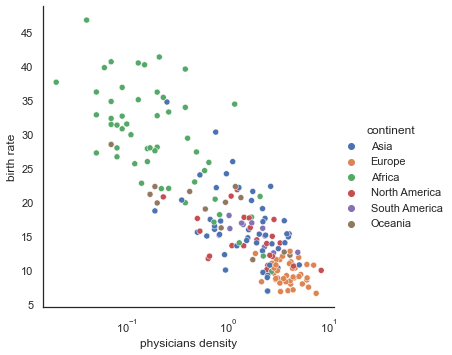

In [29]:
scales = {'gdp per capita', 'physicians density'}
for metric in features_dependent_on_birth_rate:
    g = sns.relplot(data=country_metrics, x=metric, y='birth rate', hue=country_continents['continent'])
    if metric in scales:
        g.axes[0, 0].set_xscale('log')

In [30]:
country_metrics.drop(features_dependent_on_birth_rate, axis=1, inplace=True)

In [31]:
country_metrics.shape

(193, 10)

In [32]:
country_metrics.head()

,alcohol consumption per capita,tobacco use total,birth rate,death rate,industry occupation ratio,services occupation ratio,contraceptive prevalence,health expenditures,literacy total,population below poverty
country,,,,,,,,,,
Afghanistan,0.01,23.3,34.79,12.08,18.1,37.6,18.9,15.5,37.3,54.5
Albania,4.40,22.4,12.48,7.36,18.3,40.3,46.0,6.7,98.4,14.3
Algeria,0.59,21.0,17.84,4.33,30.9,58.4,53.6,6.3,81.4,5.5
Andorra,10.99,31.8,6.87,7.98,4.4,95.1,NaN,9.1,100.0,NaN
Angola,5.84,NaN,41.42,7.80,15.0,NaN,13.7,2.9,71.1,32.3


Resulting correlations

<AxesSubplot:>

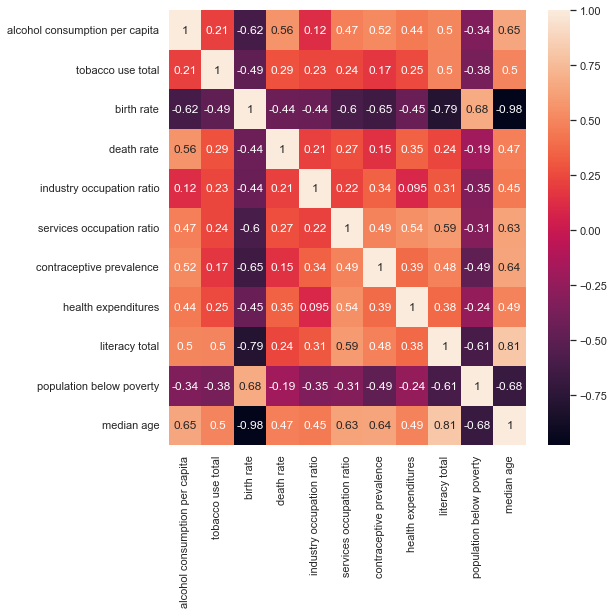

In [33]:
plt.figure(figsize=(8, 8))
sns.heatmap(pd.concat([country_metrics, median_age], axis=1).corr(method='spearman'), annot=True)

In [34]:
pearson_corr_with_median_age = country_metrics.corrwith(median_age, method='pearson')
abs_pearson_corr_with_median_age = pearson_corr_with_median_age.apply(lambda x: abs(x))
pearson_corr_with_median_age.sort_values(key=lambda x: abs(x))

industry occupation ratio         0.378867
health expenditures               0.405801
tobacco use total                 0.450943
death rate                        0.499398
contraceptive prevalence          0.616902
services occupation ratio         0.637108
population below poverty         -0.646274
alcohol consumption per capita    0.694585
literacy total                    0.699223
birth rate                       -0.914454
dtype: float64

#### Data preprocessing

There are a few tasks we're going to work on there:
1. Missing values
2. Standardization

Missing values will be replaced with the mean for a given column. Next, values will be standardized using standard scaling. Linear regression doesn't really need that, but we'll use it so that other models (like SVR) can work correctly. 

Continent metric needs to be one-hot encoded

In [35]:
num_attribs = list(country_metrics.columns)
cat_attribs = ['continent']

country_metrics['continent'] = country_continents

print("Categorical attributes: ", cat_attribs)
print("Numerical attributes: ", num_attribs)

Categorical attributes:  ['continent']
Numerical attributes:  ['alcohol consumption per capita', 'tobacco use total', 'birth rate', 'death rate', 'industry occupation ratio', 'services occupation ratio', 'contraceptive prevalence', 'health expenditures', 'literacy total', 'population below poverty']


Next, we'll build a pipeline which will fill missing values and standardize data. Sklearn algorithms will not work if there are missing values, and some of them assume that data is normally distributed. 

In [122]:
from sklearn.preprocessing import OneHotEncoder
# Column transformer will be used to apply transformation to each column 
# of data
from sklearn.compose import ColumnTransformer

num_pipeline = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean')
)

cat_pipeline = make_pipeline(
    OneHotEncoder()
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs), 
    ("cat", cat_pipeline, cat_attribs)
])

This is the set of independent variables

In [123]:
attributes = np.array(num_attribs + continents)
attributes

array(['alcohol consumption per capita', 'tobacco use total',
       'birth rate', 'death rate', 'industry occupation ratio',
       'services occupation ratio', 'contraceptive prevalence',
       'health expenditures', 'literacy total',
       'population below poverty', 'Africa', 'Asia', 'Europe',
       'North America', 'Oceania', 'South America'], dtype='<U30')

Before moving on, we'll divide the dataset for test and train sets. 

In [124]:
from sklearn.model_selection import train_test_split

df_x = country_metrics
Y = median_age.values

df_X_train, df_X_test, y_train, y_test = train_test_split(df_x, Y, test_size=0.3, 
                                            random_state=42, shuffle=True)

In [125]:
X_train_prepared = preprocessing.fit_transform(df_X_train)
X_test_prepared = preprocessing.transform(df_X_test)

### Regression Models

#### Benchmark Model
Here we are going to build a benchmark model - that is, the simplest model which then will be used to compare the performance of other models. It will be a linear regression with only one feature which has the largest correlation value. 

In [126]:
from src.models.performance import compute_performance_df, print_coef, print_for_latex_table_perf

In [127]:
feature_name = 'birth rate'
feature_index = np.flatnonzero(attributes == 'birth rate')

In [128]:
from sklearn.linear_model import LinearRegression

X_train_one_feature = X_train_prepared[:, feature_index]
X_test_one_feature = X_test_prepared[:, feature_index]

one_feature_lin_reg_model = LinearRegression()
one_feature_lin_reg_model.fit(X_train_one_feature.reshape(-1, 1), y_train)

LinearRegression()

In [129]:
print(one_feature_lin_reg_model.coef_)
print(one_feature_lin_reg_model.intercept_)

[-0.86955738]
46.38200937781889


Coefficient of determination is one of the measures of goodness of fit

In [130]:
lin_reg_perf = compute_performance_df(X_train_one_feature, y_train, X_test_one_feature, y_test, 
                       [one_feature_lin_reg_model], ['Lin Reg - one feature'])
lin_reg_perf

,R-squared,Test MSE,Train MSE
Lin Reg - one feature,0.807374,17.4788,12.004139


One feature model catches the general tendency of increasing median age with the increasing birth rate, which is logical, since more births are typical for young populations and low birth rates are typical for developed countries.

In [131]:
print(f"{feature_name} * {one_feature_lin_reg_model.coef_[0]:.2f} + {one_feature_lin_reg_model.intercept_:.2f}")

birth rate * -0.87 + 46.38


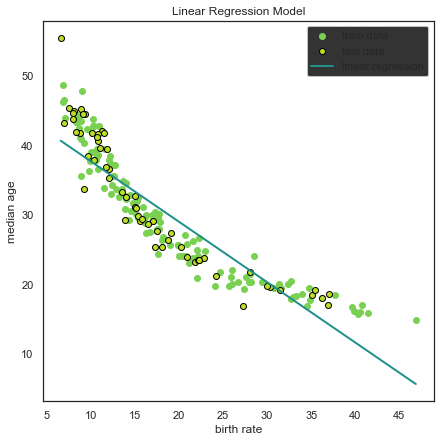

In [132]:
cmap = colormaps['viridis']

plt.figure(figsize=(7, 7))
plt.scatter(X_train_one_feature, y_train, color=cmap(0.8), label='train data')
plt.scatter(X_test_one_feature, y_test, edgecolor='black', facecolor=cmap(0.9), label='test data')
x = [df_x.loc[:, feature_name].min(), df_x.loc[:, feature_name].max()]
plt.plot(x, one_feature_lin_reg_model.predict(np.array(x).reshape(-1, 1)), color=cmap(0.5), linewidth=2.0, label='linear regression')
plt.xlabel('birth rate')
plt.ylabel('median age')
plt.title(f'Linear Regression Model')
_ = plt.legend()

In [133]:
country_metrics.columns

Index(['alcohol consumption per capita', 'tobacco use total', 'birth rate',
       'death rate', 'industry occupation ratio', 'services occupation ratio',
       'contraceptive prevalence', 'health expenditures', 'literacy total',
       'population below poverty', 'continent'],
      dtype='object')

#### Linear regression using all features



Next, we'll fit the same linear regression, but using all features. 

In [134]:
all_features_lin_reg = LinearRegression()
all_features_lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [135]:
lin_reg_perf = compute_performance_df(X_train_prepared, y_train, X_test_prepared, y_test, 
                       [all_features_lin_reg], ['Lin Reg - all features'])
lin_reg_perf

,R-squared,Test MSE,Train MSE
Lin Reg - all features,0.925394,6.769672,4.500292


In [136]:
results_df = pd.DataFrame(data=all_features_lin_reg.coef_.reshape(-1, 1), 
                          index=attributes, 
                          columns=['coef_value'])

results_df

,coef_value
alcohol consumption per capita,0.373102
tobacco use total,-0.026107
birth rate,-0.683979
death rate,0.409922
industry occupation ratio,0.044411
services occupation ratio,0.027386
contraceptive prevalence,-0.010666
health expenditures,0.144823
literacy total,-0.033563
population below poverty,-0.023068


#### Polynomial Regression with different degrees

Now, we'll try to fit models with higher degrees to capture non-linear relationships in data. 

In [137]:
from src.models.polynomial_regression import PolyRegression

We'll fit polynomial regression to the best found metric - birth rate.

In [138]:
feature_name = 'birth rate'
feature_index = np.flatnonzero(attributes == feature_name)[0]

X_train_one_feature = X_train_prepared[:, feature_index]
X_test_one_feature = X_test_prepared[:, feature_index]

In [139]:
degrees = [2, 3, 4]
poly_models = []
errors = pd.DataFrame(columns=['R-squared', 'Test MSE', 'Train MSE'], index=degrees)
errors.index.name = 'degree'

for degree in degrees:
    poly_model = PolyRegression(degree)
    poly_model.fit(X_train_one_feature.reshape(-1, 1), y_train)
    poly_models.append(poly_model)

errors = compute_performance_df(X_train_one_feature, y_train, X_test_one_feature, y_test, 
                                poly_models, [f'Polynomial={d}' for d in degrees])

In [140]:
errors

,R-squared,Test MSE,Train MSE
Polynomial=2,0.930338,6.321114,3.757043
Polynomial=3,0.941345,5.322284,2.982637
Polynomial=4,0.941433,5.314299,2.981108


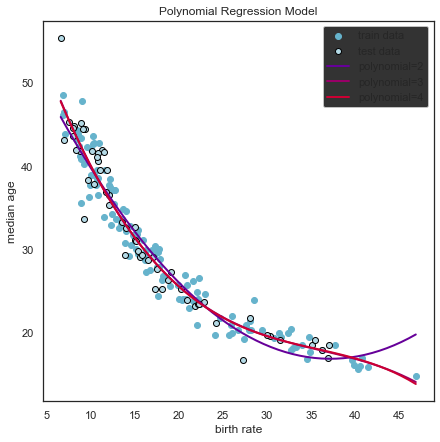

In [141]:
cmap = colormaps['ocean']

plt.figure(figsize=(7, 7))
plt.scatter(X_train_one_feature, y_train, color=cmap(0.8), label='train data')
plt.scatter(X_test_one_feature, y_test, edgecolor='black', facecolor=cmap(0.9), label='test data')

x = np.linspace(df_x.loc[:, feature_name].min(), df_x.loc[:, feature_name].max(), 50)

for p_model in poly_models:
    plt.plot(x, p_model.predict(np.array(x).reshape(-1, 1)), color=colormaps['brg'](p_model.degree / 10),
              linewidth=2.0, label=f'polynomial={p_model.degree}')

plt.xlabel('birth rate')
plt.ylabel('median age')
plt.title(f'Polynomial Regression Model')
_ = plt.legend()

We can see that for the 'birth rate' we get an improvement over the linear model, but it's worth only for the 2/3 degree. 
For the whole set of metrics the model gets overfit - the training error is small compared to the testing error

In [142]:
from src.models.performance import fit_polynomial_for_every_subset

In [143]:
polynomials_fitting_result, best_model_info = fit_polynomial_for_every_subset(X_train_prepared, y_train, X_test_prepared, y_test, [2, 3, 4], 
                                attributes, 5)

In [144]:
polynomials_fitting_result.values.astype('float')

array([[0.9526537 , 0.95280844, 0.95442687],
       [0.95867492, 0.96919121, 0.96813498],
       [0.96350496, 0.97654016, 0.9689713 ],
       [0.96577939, 0.97490888, 0.96980961]])

Text(0, 0.5, 'number of features')

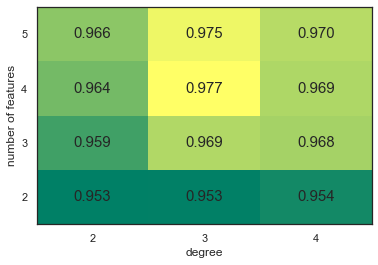

In [145]:
plt.pcolormesh(polynomials_fitting_result.values.astype('float'),
                cmap='summer')
plt.xticks(np.arange(3) + 0.5, np.arange(2, 5))
plt.yticks(np.arange(4) + 0.5, np.arange(2, 6))

for y in range(4):
    for x in range(3):
        plt.text(x + 0.5, y + 0.5, '%.3f' % polynomials_fitting_result.values[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=15)
        
plt.xlabel('degree')
plt.ylabel('number of features')

In [146]:
best_model, model_attr = best_model_info
model_attr

array(['birth rate', 'health expenditures', 'population below poverty',
       'Europe'], dtype='<U30')

In [147]:
best_model.degree

3

In [148]:
[np.flatnonzero(np.isin(attributes, model_attr))]

[array([ 2,  7,  9, 12], dtype=int64)]

In [149]:
best_model.score(X_test_prepared[:, np.flatnonzero(np.isin(attributes, model_attr))], y_test)

0.9765401602903533

In [150]:
best_model.coef_

array([-18.68813768,   3.806809  ,  -2.50806616,  -2.2905358 ,
        21.08601655, -14.29398402,   6.21180176,   6.4045884 ,
         1.45110895,   6.47232301,  -2.55327219,  -4.77939671,
         2.88253915,  -2.2905358 ,  -7.90159704,   7.12193604,
        -4.77427804,  -6.98328211,   7.4775842 ,  -2.55221421,
         2.1214798 ,   3.57834317,  -0.83544176,   6.4045884 ,
        -2.62969378,  -4.79976499,   5.08352994,  -0.13810801,
        -6.514382  ,  -2.55327219,   0.9289933 ,   1.1369308 ,
         2.88253915,  -2.2905358 ])

We can see that for the 'birth rate' we get an improvement over the linear model, but it's worth only for the 2/3 degree. 
For the whole set of metrics the model gets overfit - the training error is small compared to the testing error

#### SVR with different parameter sets

We will also try support vector regression with different parameter sets. First, we'll try linear support vector regression

In [151]:
num_pipeline = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

X_train_prepared_svr = preprocessing.fit_transform(df_X_train)
X_test_prepared_svr = preprocessing.transform(df_X_test)

In [152]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

tuned_params = [{'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100]},
    {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.01], 
     'kernel': ['rbf', 'poly'], 'degree': [2, 3, 5]      # degree is only for polynomial
    }]

grid_search = GridSearchCV(SVR(), tuned_params, scoring='neg_mean_squared_error',
                           verbose=3)

grid_search.fit(X_train_prepared_svr, y_train)

Fitting 5 folds for each of 95 candidates, totalling 475 fits
[CV 1/5] END ...........C=0.01, kernel=linear;, score=-29.574 total time=   0.0s
[CV 2/5] END ...........C=0.01, kernel=linear;, score=-42.498 total time=   0.0s
[CV 3/5] END ...........C=0.01, kernel=linear;, score=-37.565 total time=   0.0s
[CV 4/5] END ...........C=0.01, kernel=linear;, score=-46.909 total time=   0.0s
[CV 5/5] END ...........C=0.01, kernel=linear;, score=-32.370 total time=   0.0s
[CV 1/5] END .............C=0.1, kernel=linear;, score=-8.673 total time=   0.0s
[CV 2/5] END .............C=0.1, kernel=linear;, score=-6.216 total time=   0.0s
[CV 3/5] END .............C=0.1, kernel=linear;, score=-6.322 total time=   0.0s
[CV 4/5] END ............C=0.1, kernel=linear;, score=-10.983 total time=   0.0s
[CV 5/5] END ............C=0.1, kernel=linear;, score=-15.672 total time=   0.0s
[CV 1/5] END ...............C=1, kernel=linear;, score=-7.041 total time=   0.0s
[CV 2/5] END ...............C=1, kernel=linear;

GridSearchCV(estimator=SVR(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 5],
                          'gamma': [0.0001, 0.001, 0.01],
                          'kernel': ['rbf', 'poly']}],
             scoring='neg_mean_squared_error', verbose=3)

In [153]:
svr = grid_search.best_estimator_
svr

SVR(C=100, degree=2, gamma=0.01)

In [154]:
compute_performance_df(X_train_prepared_svr, y_train, X_test_prepared_svr, y_test,
                       [svr], ['Support Vector Regression'])

,R-squared,Test MSE,Train MSE
Support Vector Regression,0.933369,6.04609,1.589461


The result did not improve over the linear regression, and the model has higher computational complexity.

#### Extra Model
Another highly correlated metric was literacy, so it's worth checking what pattern it represents.

In [156]:
feature_name = 'literacy total'
feature_index = np.flatnonzero(attributes == feature_name)[0]
degree = 2

X_train_one_feature = X_train_prepared[:, feature_index]
X_test_one_feature = X_test_prepared[:, feature_index]

one_feature_lin_reg_model = LinearRegression()
one_feature_lin_reg_model.fit(X_train_one_feature.reshape(-1, 1), y_train)

poly_model = PolyRegression(degree)
poly_model.fit(X_train_one_feature.reshape(-1, 1), y_train)

In [157]:
compute_performance_df(X_train_one_feature, y_train, X_test_one_feature,
                       y_test, [one_feature_lin_reg_model, poly_model], ['Linear', 'Quadratic'])

,R-squared,Test MSE,Train MSE
Linear,0.28478,64.898632,48.063051
Quadratic,0.249468,68.10287,44.971729


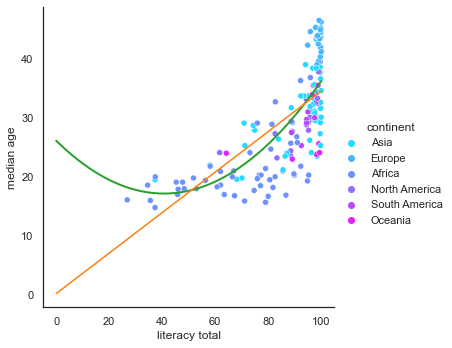

In [158]:
cmap = colormaps['ocean']

g = sns.relplot(data=country_metrics, x='literacy total',
            y=median_age, hue=country_continents.continent,
            palette='cool')

x = np.linspace(0, 100, 50)

plt.plot(x, poly_model.predict(x.reshape(-1, 1)), color='tab:green',
             linewidth=2.0, label=f'polynomial={poly_model.degree}')
plt.plot(x, one_feature_lin_reg_model.predict(x.reshape(-1, 1)),
        color='tab:orange', label='linear')